# Notebook for calculating the "found-by-testing" ratio numerically for a range of beta and tau 
And possibly making heatmaps of the results

In [230]:
%matplotlib widget

import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf
import PandemiXModelFunctions as pmf

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)

import datetime
             
from scipy.integrate import cumtrapz
# int_I = cumtrapz(np.exp(u_H*ts)*Is,ts, initial=0)
# Hs = np.exp(-u_H*ts) * (r_chr*pars_full['gamma']*int_I + k) 

In [231]:
# Model with explicit symptomatic category and keeping track of whether recovered were found or not
modelMeta = ({
     'beta * S * (P+A)' : ['S','E1'],
     'gamma * E1' : ['E1','E2'],
     'gamma * E2' : ['E2','P'],
     'gamma * rho * P' : ['P','I'],
     'gamma * (1-rho) * P' : ['P','A'],
     'nu * A' : ['A',None],
     'nu * Q' : ['Q','Rp'],
     # 'nu * I' : ['I',None],
     'nu * I' : ['I','Rp'], # Assuming that symptomatic cases get tested, but aren't included in Q 
     'tau * E2' : ['E2','Q'],
     'tau * P'  : ['P','Q'],
     'tau * A'  : ['A','Q'],
     # 'tau * I'  : ['I','Q'], # Testing of symptomatic cases
     # 'tauInf * I'  : ['I','Q'], # Testing of symptomatic cases
     
},
['S','E1','E2','P','A','Q','I','Rp'],['beta','gamma','nu','rho','tau'])


In [232]:
def calcFoundRatioFinal(pars):
    gamma = pars['gamma']
    nu = pars['nu']
    rho = pars['rho']
    tau = pars['tau']
    
    toReturn = 1 - (nu/(nu+tau))*(1-tau/(gamma+tau))*(1-(gamma*rho+tau)/(gamma+tau))
    return toReturn

In [233]:
def calcFoundRatioBefore(pars):
    beta = pars['beta']
    gamma = pars['gamma']
    nu = pars['nu']
    rho = pars['rho']
    tau = pars['tau']
    
    Amat = np.array(
        [
            #S    E1        E2          P           I       A       Q Rp  Rn    
            [0,      0,          0,         -beta,  0,     -beta,   0, 0, 0],
            [0, -gamma,          0,          beta,  0,      beta,   0, 0, 0],
            [0,  gamma, -gamma-tau,             0,  0,         0,   0, 0, 0],
            [0,      0,      gamma,    -gamma-tau,  0,         0,   0, 0, 0],
            [0,      0,          0,     gamma*rho,-nu,         0,   0, 0, 0],
            [0,      0,          0, gamma*(1-rho),  0,   -nu-tau,   0, 0, 0],
            [0,      0,        tau,           tau,  0,       tau, -nu, 0, 0],
            [0,      0,          0,             0, nu,         0,  nu, 0, 0],
            [0,      0,          0,             0,  0,        nu,   0, 0, 0]
        ]
    )

    eigval,eigvec = np.linalg.eig(Amat)

    maxEigIndex = np.argmax(eigval)
    eigRP = eigvec[7,maxEigIndex]
    eigRN = eigvec[8,maxEigIndex]

    ratioBefore = np.real(eigRP/(eigRP+eigRN))
    return ratioBefore 

In [234]:
def getBetaFromTauAndSigma(tau,sigma,pars):

    gamma = pars['gamma']
    nu = pars['nu']
    rho = pars['rho']

    estiTE = (1-sigma)/(gamma+tau)
    estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
    estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

    beta = -np.log(sigma)/(estiTP+estiTA)
    

    return beta 

# Make a small test

In [235]:
# Initialize everything
iniExp = 100/5800000

# E1_0 = iniExp 
# E2_0 = 0
# P_0 = 0
E1_0 = iniExp
E2_0 = 0
P_0 = 0  
A_0 = 0 
I_0 = 0 
S_0 = 1 - E1_0 -E2_0 - P_0 - A_0-I_0

init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':0,'I':I_0,'Rp':0}

gamma = 1/3
nu = 1/3
rho = 0.5
beta = 3*gamma
tau = 0.2
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = 300
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])

# changeTest = pmf.Change(10,SetParameters={})
# sch1.addChange(changeTest)

sch1.simulate(tRes=1000)

In [236]:
ratioFinal = calcFoundRatioFinal(pars)
ratioBefore = calcFoundRatioBefore(pars)

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_23192\1920432918.py:7: RuntimeWarning: invalid value encountered in true_divide
  curRatio = 100*sch1.result.Rp/(sch1.result.Rp+Rn)


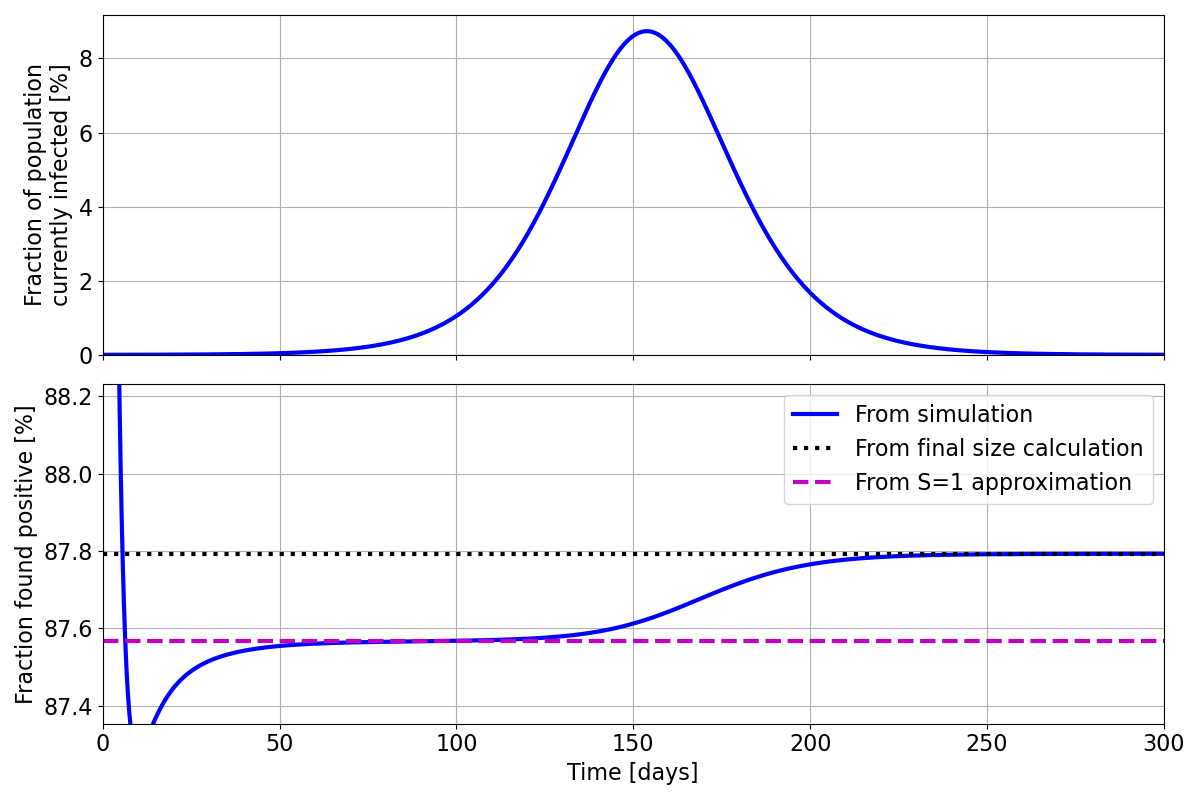

In [237]:
fig,(ax,ax2) = plt.subplots(2,1,sharex=True)

allInf = sch1.result.E1 + sch1.result.E2 + sch1.result.P + sch1.result.I + sch1.result.Q + sch1.result.A

Rn = 1 - sch1.result.y.sum(axis=0)

curRatio = 100*sch1.result.Rp/(sch1.result.Rp+Rn)

ax.plot(sch1.result.t,100*allInf,'b')
ax2.plot(sch1.result.t,curRatio,'b',label='From simulation')

ax2.axhline(100*ratioFinal,color='k',linestyle=':',label='From final size calculation')
ax2.axhline(100*ratioBefore,color='m',linestyle='--',label='From S=1 approximation')

ax2.set_ylim(curRatio[-1]*np.array([0.995,1.005]))
# ax2.set_ylim(curRatio[-1]*np.array([0.995,1.05]))

ax.set_xlim([sch1.result.t[0],sch1.result.t[-1]])
ax2.set_xlim([sch1.result.t[0],sch1.result.t[-1]])
ax.set_ylim(bottom=0)

ax2.set_xlabel('Time [days]')
ax.set_ylabel('Fraction of population\ncurrently infected [%]')
ax2.set_ylabel('Fraction found positive [%]')

ax.grid()
ax2.grid()

ax2.legend()

fig.tight_layout()
fig.savefig('Figures/TestIntensity_ExampleTestRatioWithLevels')

# Investigate range

In [238]:
# betaRange = np.linspace(gamma,4*gamma,10) 
# tauRange = np.linspace(0,0.2,10)
betaRange = np.linspace(gamma/3,3,100) 
tauRange = np.linspace(0,0.5,100)
betaRange = np.linspace(0,2,100) 
tauRange = np.linspace(0,0.2,100)
betaRange = np.linspace(0,2,1000) 
tauRange = np.linspace(0,0.2,1000)

[XX,YY] = np.meshgrid(betaRange,tauRange)

ratioBefores = np.zeros(XX.shape)
ratioFinals = np.zeros(XX.shape)


# for i,beta in enumerate(betaRange):
#     for j,tau in enumerate(tauRange):
#         pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}

#         ratioFinal = calcFoundRatioFinal(pars)
#         ratioBefore = calcFoundRatioBefore(pars)

#         XX[i,j] = beta
#         YY[i,j] = tau 
#         ratioBefores[i,j] = ratioBefore
#         ratioFinals[i,j] = ratioFinal
        
for i,tau in enumerate(tauRange):
    for j,beta in enumerate(betaRange):
        pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}

        ratioFinal = calcFoundRatioFinal(pars)
        ratioBefore = calcFoundRatioBefore(pars)

        XX[i,j] = tau
        YY[i,j] = beta
        ratioBefores[i,j] = ratioBefore
        ratioFinals[i,j] = ratioFinal

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_23192\3116368344.py:29: RuntimeWarning: invalid value encountered in double_scalars
  ratioBefore = np.real(eigRP/(eigRP+eigRN))
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_23192\3116368344.py:29: RuntimeWarning: invalid value encountered in cdouble_scalars
  ratioBefore = np.real(eigRP/(eigRP+eigRN))


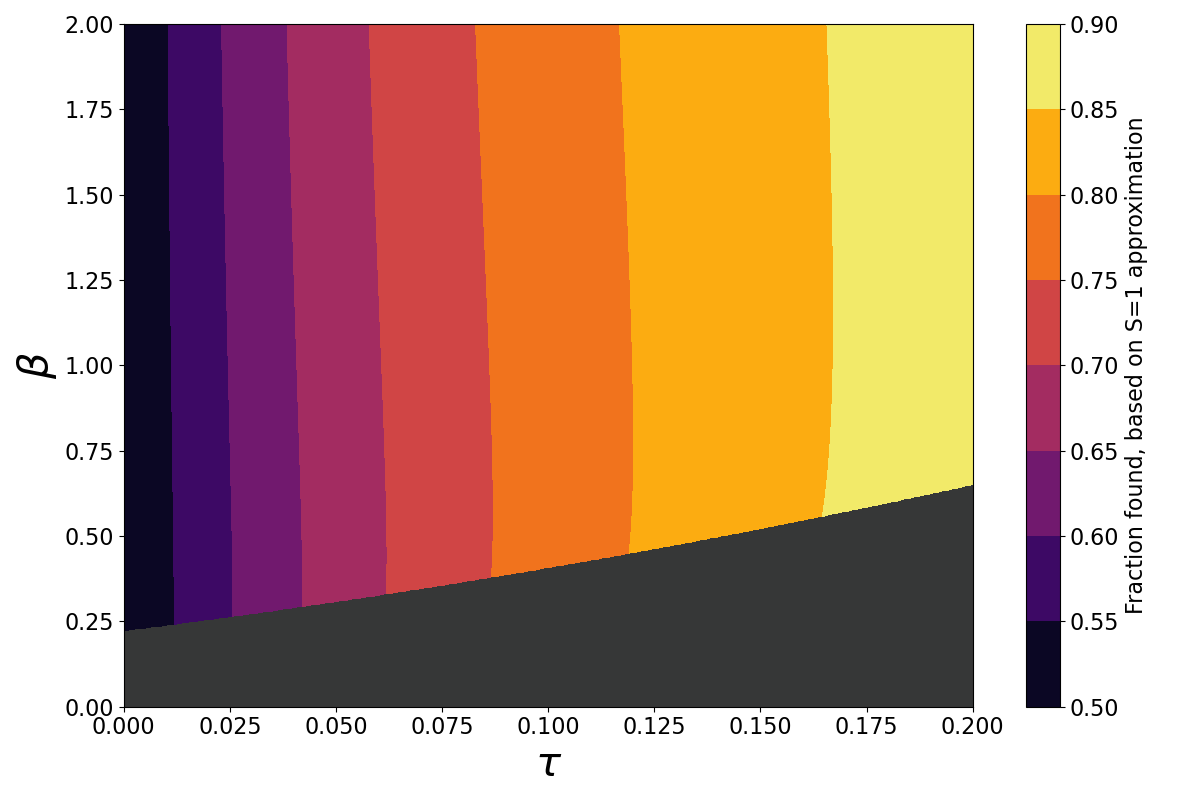

In [239]:
fig,ax = plt.subplots()

ax.set_facecolor('xkcd:dark gray')
CS = ax.contourf(XX,YY,ratioBefores,cmap='inferno')
cbar = fig.colorbar(CS)

cbar.ax.set_ylabel('Fraction found, based on S=1 approximation')

ax.set_xlabel(r'$\tau$',fontsize=30)
ax.set_ylabel(r'$\beta$',fontsize=30)
fig.tight_layout()

fig.savefig('Figures/TestIntensity_RatioBefore')

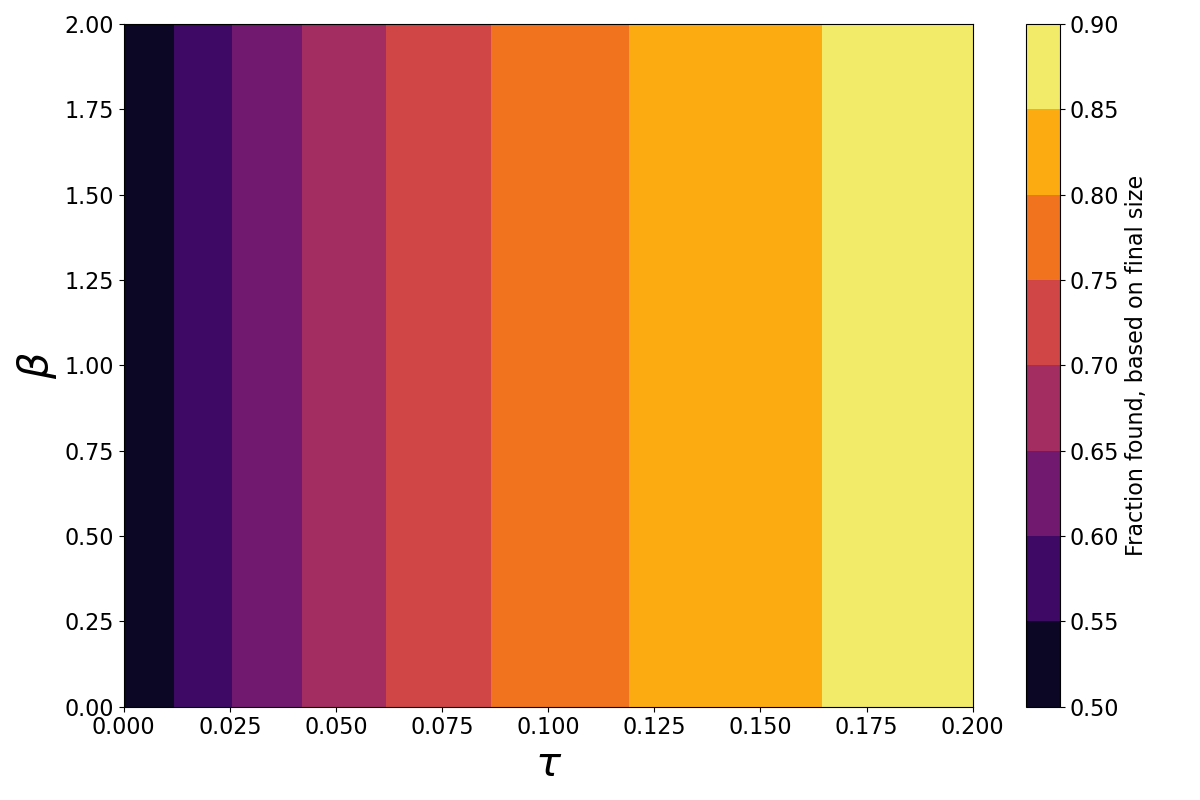

In [240]:
fig,ax = plt.subplots()

CS = ax.contourf(XX,YY,ratioFinals,cmap='inferno')
cbar = fig.colorbar(CS)

cbar.ax.set_ylabel('Fraction found, based on final size')

ax.set_xlabel(r'$\tau$',fontsize=30)
ax.set_ylabel(r'$\beta$',fontsize=30)
fig.tight_layout()

fig.savefig('Figures/TestIntensity_RatioFinal')

In [269]:

# surfaceToShow = ratioFinals-ratioBefores

# curMax = np.nanmax(surfaceToShow)
# curMin = np.nanmin(surfaceToShow)
# vRange = np.concatenate([np.linspace(curMin,0,6)[:-1],np.linspace(0,curMax,6)])
# vRange

# fig,ax = plt.subplots()
# ax.set_facecolor('xkcd:dark gray')
# CS = ax.contourf(XX,YY,ratioFinals-ratioBefores,levels=vRange,cmap='inferno')
# cbar = fig.colorbar(CS)

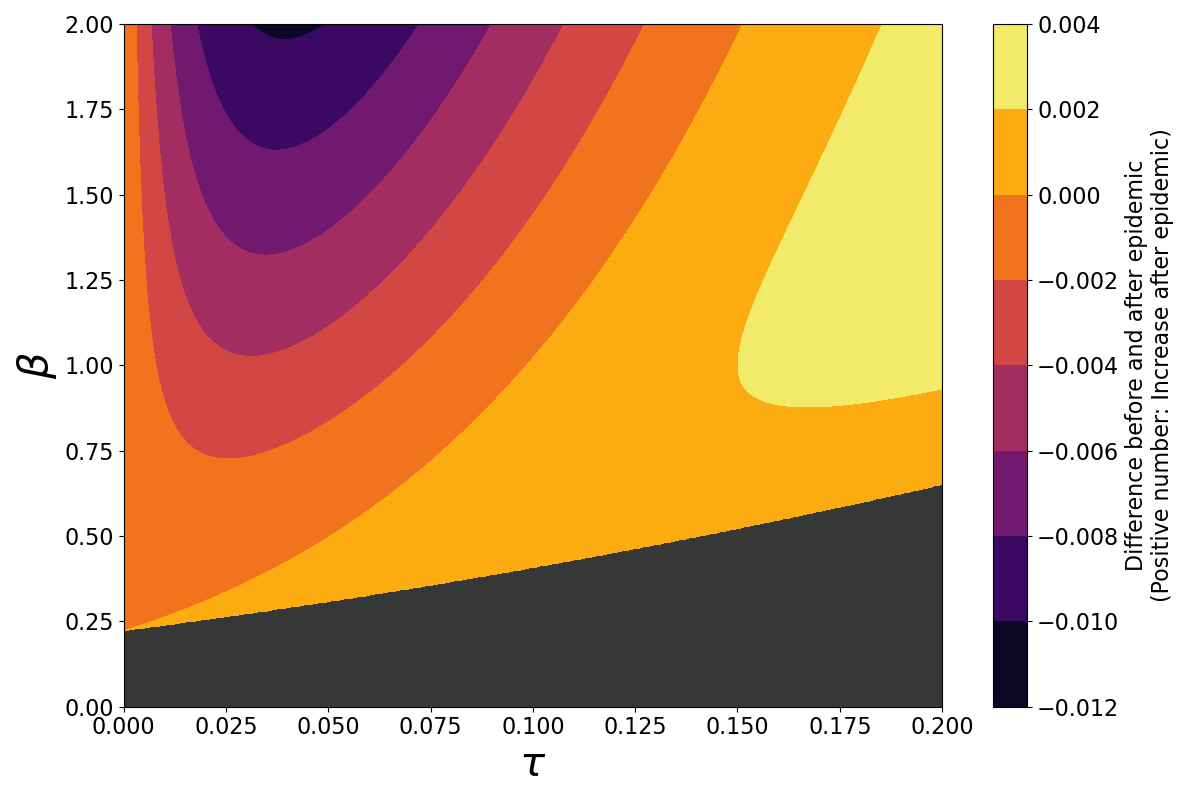

In [268]:
fig,ax = plt.subplots()

# surfaceToShow = ratioFinals-ratioBefores

# curMax = np.nanmax(surfaceToShow)
# curMin = np.nanmin(surfaceToShow)
# vRange = np.linspace(curMin)

ax.set_facecolor('xkcd:dark gray')
CS = ax.contourf(XX,YY,ratioFinals-ratioBefores,cmap='inferno')
cbar = fig.colorbar(CS)
curVals = cbar.values

cbar.ax.set_ylabel('Difference before and after epidemic')
cbar.ax.set_ylabel('Difference before and after epidemic\n(Positive number: Increase after epidemic)')

ax.set_xlabel(r'$\tau$',fontsize=30)
ax.set_ylabel(r'$\beta$',fontsize=30)
fig.tight_layout()

fig.savefig('Figures/TestIntensity_RatioDifference')

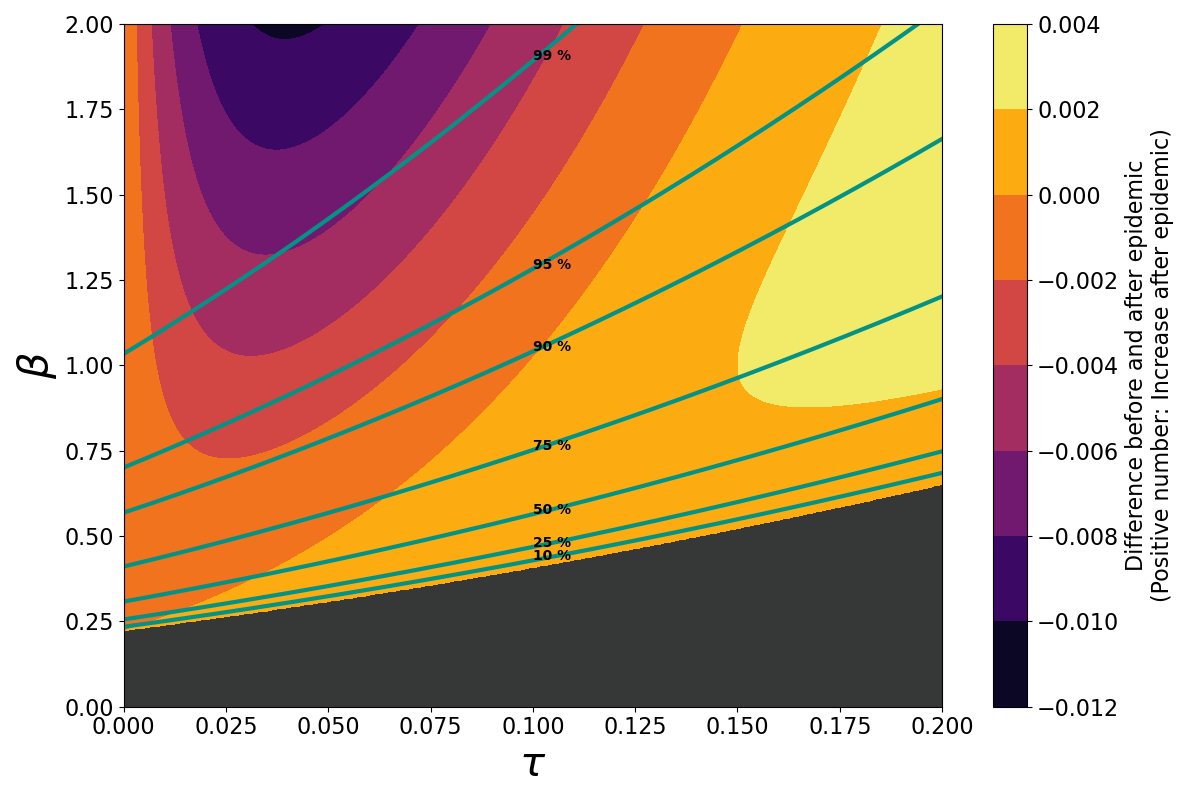

In [248]:

fig,ax = plt.subplots()
ax.set_facecolor('xkcd:dark gray')

CS = ax.contourf(XX,YY,ratioFinals-ratioBefores,cmap='inferno')
# CS = ax.contourf(XX,YY,100*(ratioFinals-ratioBefores),cmap='inferno')
cbar = fig.colorbar(CS)

cmap = plt.cm.get_cmap('summer',10)

sigmaRange = np.arange(0,0.7,0.1)
sigmaRange = np.array([0.01,0.05,0.1,0.25,0.5,0.75,0.9])
# sigmaRange = np.arange(0.05,0.7,0.05)
# for sigma in sigmaRange:
for i,sigma in enumerate(sigmaRange):
    lineToShow = np.zeros(tauRange.shape)
    for j,tau in enumerate(tauRange):
        
        lineToShow[j] = getBetaFromTauAndSigma(tau,sigma,pars)
    # ax.plot(tauRange,lineToShow,color=cmap(i))
    ax.plot(tauRange,lineToShow,color='xkcd:teal')
    mi = int(len(tauRange)/2)
    ax.text(tauRange[mi],lineToShow[mi],f'{100*np.around(1-sigma,2):2.0f} %',fontsize=10,weight='bold')

ax.set_ylim([betaRange[0],betaRange[-1]])

cbar.ax.set_ylabel('Difference before and after epidemic')
cbar.ax.set_ylabel('Difference before and after epidemic\n(Positive number: Increase after epidemic)')

ax.set_xlabel(r'$\tau$',fontsize=30)
ax.set_ylabel(r'$\beta$',fontsize=30)
fig.tight_layout()
fig.savefig('Figures/TestIntensity_RatioDifferenceLines')

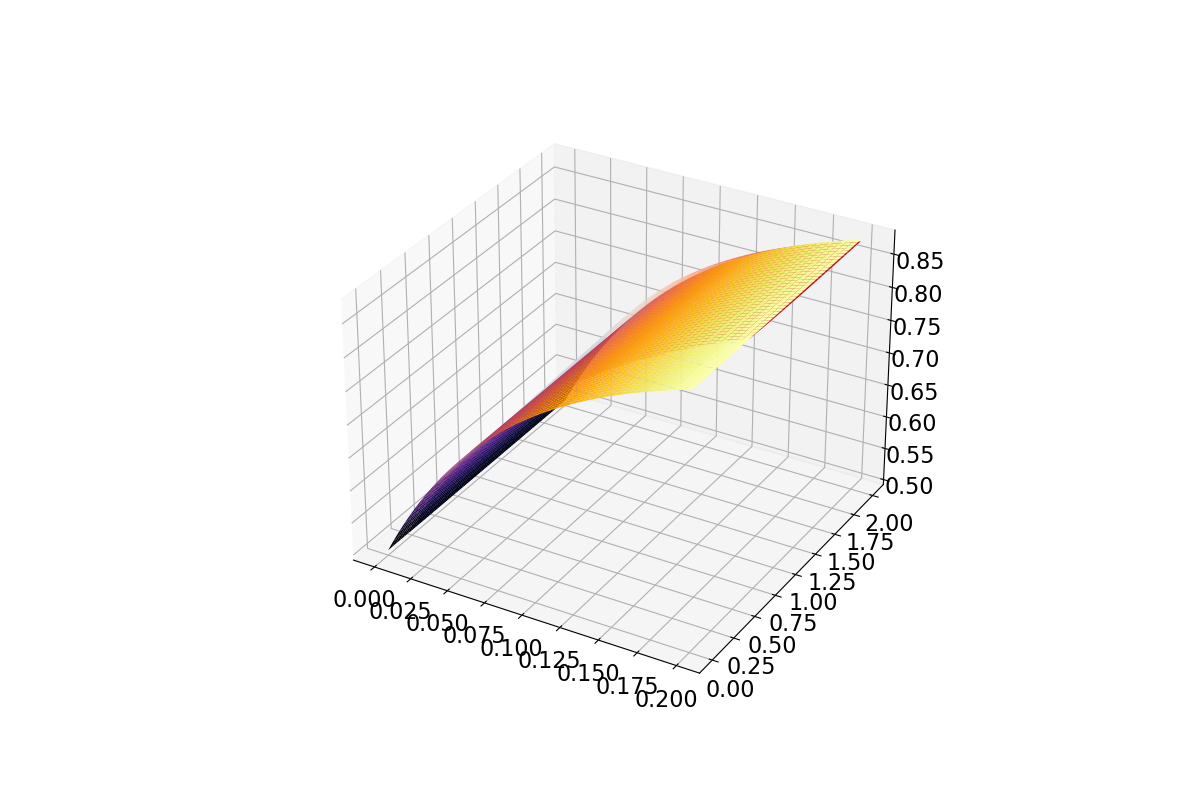

In [243]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(XX, YY, ratioFinals,cmap='inferno',linewidth=0)
ax.plot_surface(XX, YY, ratioBefores,cmap='coolwarm',linewidth=0)

In [244]:

# curMax = np.nanmax(surfaceToShow)
# curMin = np.nanmin(surfaceToShow)

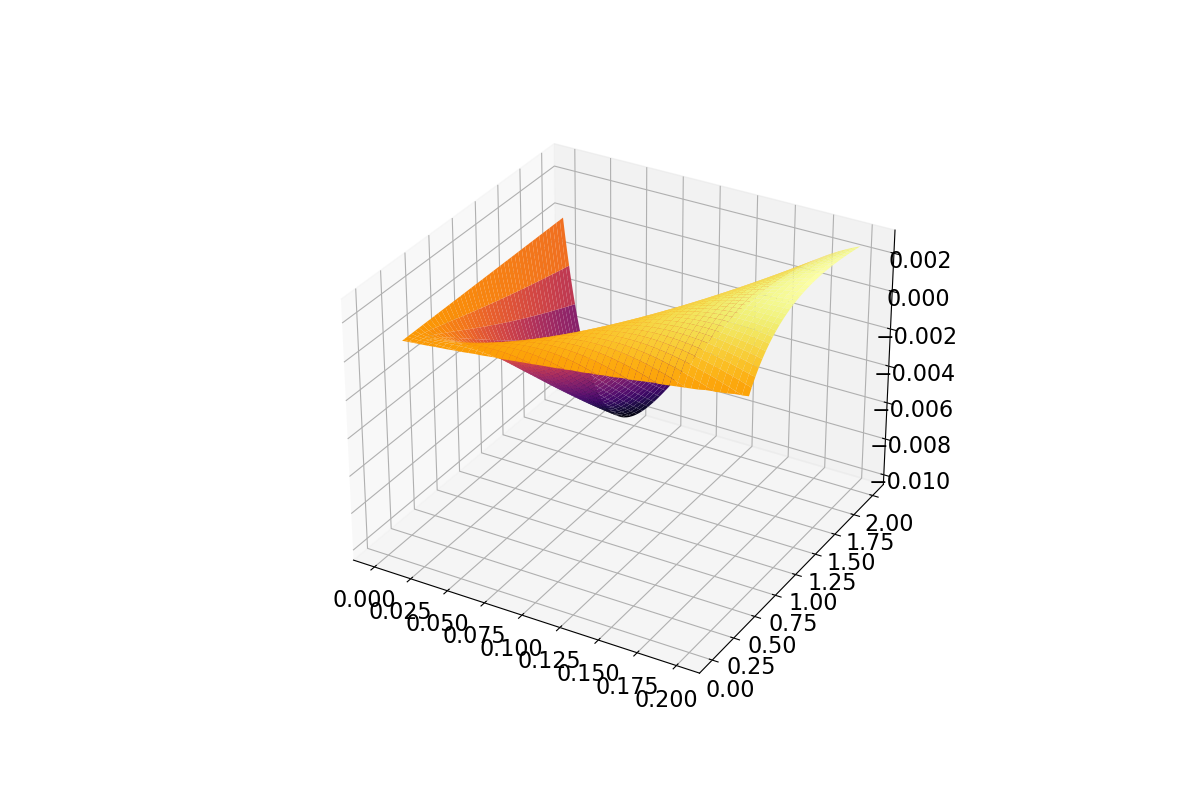

In [245]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surfaceToShow = ratioFinals-ratioBefores

curMax = np.nanmax(surfaceToShow)
curMin = np.nanmin(surfaceToShow)

ax.plot_surface(XX, YY, surfaceToShow ,cmap='inferno',linewidth=0,vmin=curMin,vmax=curMax)
# ax.plot_surface(XX,YY,0*ratioFinals,linewidth=0,alpha=.1,color='gray',aa=False,zorder=1)
# newSurf = surfaceToShow.copy()
# newSurf[newSurf < 0] = np.nan
# ax.plot_surface(XX, YY, newSurf,cmap='inferno',linewidth=0,alpha=1,vmin=curMin,vmax=curMax,zorder=3)

# With smaller values of tau

In [275]:
# # betaRange = np.linspace(gamma,4*gamma,10) 
# # tauRange = np.linspace(0,0.2,10)
# betaRange = np.linspace(gamma/3,3,100) 
# tauRange = np.linspace(0,0.5,100)
# betaRange = np.linspace(0,2,100) 
# tauRange = np.linspace(0,0.2,100)
betaRange2 = np.linspace(0.2,0.6,1000) 
tauRange2 = np.linspace(0,0.05,1000)

[XX2,YY2] = np.meshgrid(betaRange2,tauRange2)

ratioBefores2 = np.zeros(XX2.shape)
ratioFinals2 = np.zeros(XX2.shape)

for i,tau in enumerate(tauRange2):
    for j,beta in enumerate(betaRange2):
        pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}

        ratioFinal = calcFoundRatioFinal(pars)
        ratioBefore = calcFoundRatioBefore(pars)

        XX2[i,j] = tau
        YY2[i,j] = beta
        ratioBefores2[i,j] = ratioBefore
        ratioFinals2[i,j] = ratioFinal

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_23192\3116368344.py:29: RuntimeWarning: invalid value encountered in cdouble_scalars
  ratioBefore = np.real(eigRP/(eigRP+eigRN))


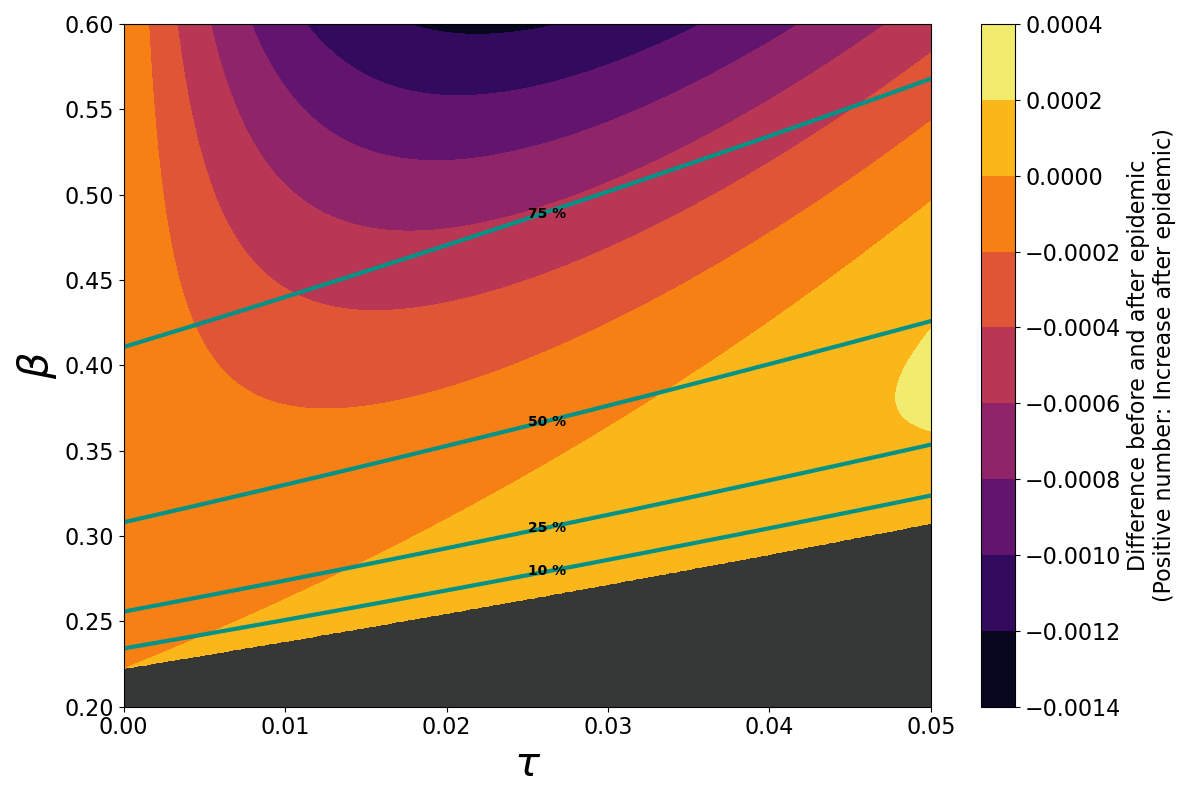

In [276]:

fig,ax = plt.subplots()
ax.set_facecolor('xkcd:dark gray')

CS = ax.contourf(XX2,YY2,ratioFinals2-ratioBefores2,cmap='inferno')
# CS = ax.contourf(XX2,YY2,ratioFinals2-ratioBefores2,levels=curVals,cmap='inferno')
cbar = fig.colorbar(CS)
# curVals = cbar.values

cmap = plt.cm.get_cmap('summer',10)

sigmaRange = np.arange(0,0.7,0.1)
sigmaRange = np.array([0.01,0.05,0.1,0.25,0.5,0.75,0.9])
sigmaRange = np.array([0.25,0.5,0.75,0.9])
# sigmaRange = np.arange(0.05,0.7,0.05)
# for sigma in sigmaRange:
for i,sigma in enumerate(sigmaRange):
    lineToShow = np.zeros(tauRange2.shape)
    for j,tau in enumerate(tauRange2):
        
        lineToShow[j] = getBetaFromTauAndSigma(tau,sigma,pars)
    # ax.plot(tauRange2,lineToShow,color=cmap(i))
    ax.plot(tauRange2,lineToShow,color='xkcd:teal')
    mi = int(len(tauRange2)/2)
    ax.text(tauRange2[mi],lineToShow[mi],f'{100*np.around(1-sigma,2):2.0f} %',fontsize=10,weight='bold')

ax.set_ylim([betaRange2[0],betaRange2[-1]])

cbar.ax.set_ylabel('Difference before and after epidemic')
cbar.ax.set_ylabel('Difference before and after epidemic\n(Positive number: Increase after epidemic)')

ax.set_xlabel(r'$\tau$',fontsize=30)
ax.set_ylabel(r'$\beta$',fontsize=30)
fig.tight_layout()
fig.savefig('Figures/TestIntensity_RatioDifferenceLines_Zoom')